In [4]:
import matplotlib.pyplot as plt

from calibration.calibration import *

Set the variables for the experiment:

- experiment_name = name of the calibration experiment, used for naming the result.
- model_name = name of the model used for the recommendations, used for naming the results. IMPORTANT: this notebook does not generate recommendations, this must be generated using Elliot and passed through reco_file.
- top_k = quantity of recommendations, is important to note that from Elliot, is recommended to do a top_k of all the users in the dataset, because the calibration needs all the scores, if the top_k of Elliot and this notebook match, the calibration will not have effect.
- lmbda = Amount of calibration to apply. Must be between 0 and 1 inclusive. Closer to 1 means more.
- xxx_file = List that includes in the first element a string indicating the data type (only tsv and csv are supported for now), and the second element contains the path to the file.

For files, from Elliot, it is required to generate recommendations AND the split (only the train is required, but Elliot generates both). For more information, check Elliot documentation.

The attribute file MUST be provided, this should be part of the dataset used. For example, movielens comes with the ratings and an acompanying dataset containing the genres for each movie. It should have the columns itemid, title and attribute. The dataset must not have columns, they will be generated inside the module,  same goes for the other 2 datasets.

In [2]:
experiment_name = 'movielens-1m'
model_name = 'wrmf'
top_k = 50
lmbda = 0.99

attr_file = ['csv', './data/movielens-1m/movies.csv']
train_file = ['tsv', './data/movielens-1m/latent/split/0/train.tsv']
reco_file = ['tsv', './data/movielens-1m/latent/recs/WRMF_seed=42_e=10_bs=-1_factors=10_alpha=1_reg=0$1_it=2.tsv']

Generate the calibration object.

In [5]:
test = Calibration()

Sets the configuration for the calibration experiment, this is used to reset the experiment and generate the attributes.

In [6]:
test.set_config(
    model_name, attr_file, train_file, reco_file, top_k, lmbda
)

Here it will generate the interacted and recommended distributions for all users.

In [7]:
test.prepare()

Calculating distributions...: 100%|██████████| 6037/6037 [02:49<00:00, 35.60it/s]


This is the calibration.

TODO: Give the option to generate the calibration for all users. Now is done for only the 10% with the worst calibration metric.

In [8]:
test.calibrate()

Calibrating...: 100%|██████████| 603/603 [1:05:24<00:00,  6.51s/it]


This will generate tables for the average distributions + deltas for before and after calibration, and the distributions and deltas for a single user from the ones with the worst calibration metric.

TODO: Again, give the option to choose random user from all the users, or an specific user. And either make the method return the tables or save them as csv instead of saving them to an attribute.

In [9]:
test.generate_tables()

Now the tables are saved as CSV.

TODO: Convert to a method in the object.

In [11]:
save_path = './results/'
prefix = experiment_name + '_' + model_name + '_' + str(top_k) + '_' + str(lmbda) + '_'

pd.DataFrame(test.inter_distr).fillna(0).to_csv(
    save_path + prefix + 'inter_distr.csv'
)

pd.DataFrame(test.recom_distr).fillna(0).to_csv(
    save_path + prefix + 'recom_distr.csv'
)

pd.DataFrame(test.calib_distr).fillna(0).to_csv(
    save_path + prefix + 'calib_distr.csv'
)

pd.DataFrame(test.single_table).fillna(0).to_csv(
    save_path + prefix + 'single_table.csv'
)

pd.DataFrame(test.average_table).fillna(0).to_csv(
    save_path + prefix + 'average_table.csv'
)

And we generate plots showcasing the results from the calibration for the average...

TODO: Maybe convert to a method in the object.

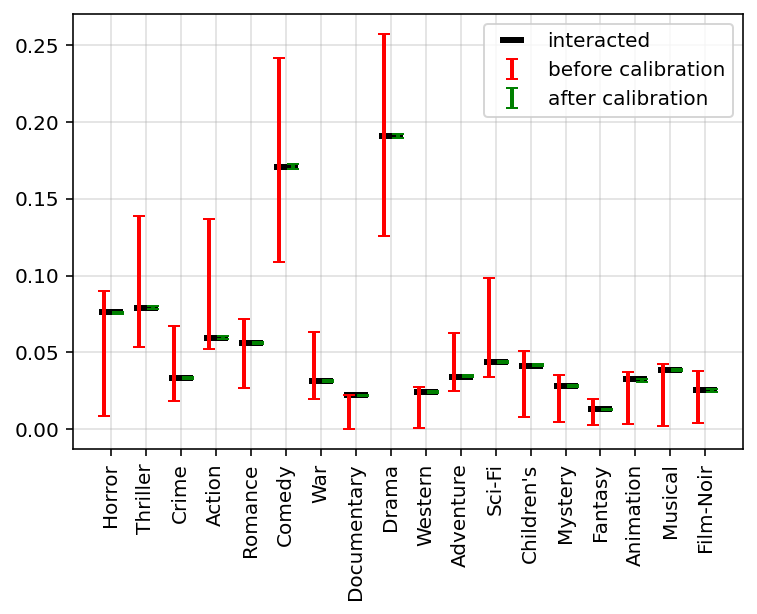

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

info_table_final = pd.DataFrame(test.average_table).fillna(0)

info_table_final = info_table_final.sort_index()

n = info_table_final.shape[0]
index = np.arange(n)

plt.plot(index, info_table_final['inter_distr'], '_',
    ms=12.0, mew=3.0, mec='k', label='interacted')

pre_yerr = [
    -np.array(info_table_final['neg_pre_delta'].to_list()),
    np.array(info_table_final['pos_pre_delta'].to_list())
]
post_yerr = [
    -np.array(info_table_final['neg_post_delta'].to_list()),
    np.array(info_table_final['pos_post_delta'].to_list())
]

plt.errorbar(index - 0.2, info_table_final['inter_distr'], yerr=pre_yerr,
    fmt=' ', lw=2, capsize=3, label='before calibration', ecolor='r')
plt.errorbar(index + 0.2, info_table_final['inter_distr'], yerr=post_yerr,
    fmt=' ', lw=2, capsize=3, label='after calibration', ecolor='g')

plt.legend()

plt.xticks(index, info_table_final.index, rotation=90)
plt.grid(alpha=0.4)
plt.show()

...and for the single user choosen randomly from the users with the worst calibration metric.

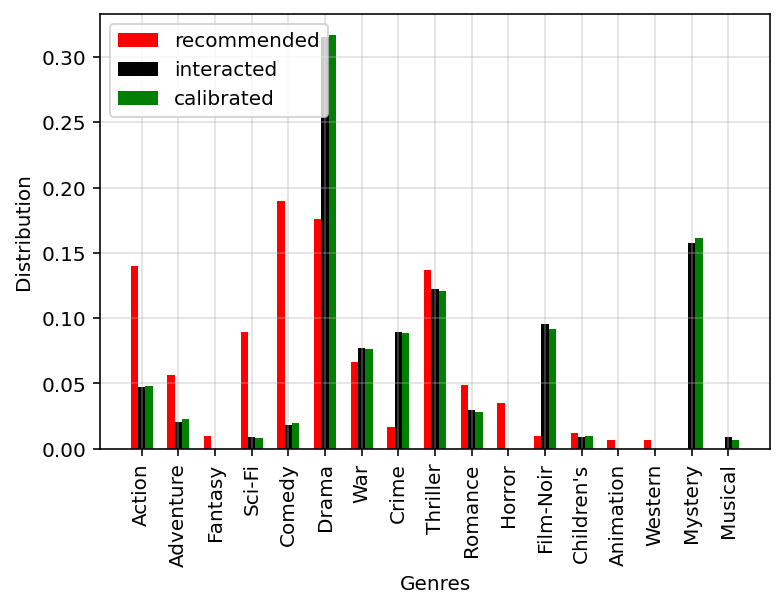

In [13]:
df = pd.DataFrame({
    'recommended': test.single_table['recom_distr'],
    'interacted': test.single_table['inter_distr'],
    'calibrated': test.single_table['calib_distr']
})

n = df.shape[0]
index = np.arange(n)

plt.bar(index - 0.2, df['recommended'], width=0.2, label='recommended', color='r')
plt.bar(index, df['interacted'], width=0.2, label='interacted', color='k')
plt.bar(index + 0.2, df['calibrated'], width=0.2, label='calibrated', color='g')

plt.xticks(index, df.index, rotation=90)
plt.legend()
plt.grid(True, alpha=0.4)

plt.xlabel('Genres')
plt.ylabel('Distribution')
plt.show()